In [6]:
# importamos los 3 documentos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
detecciones = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/detections_SNe_v7.0.1.csv")
matches = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/dfcrossmatches_prioritized_v7.0.1.csv")
features_clean = pd.read_parquet("/content/drive/MyDrive/Archivos_ALeRCE/features_cleaned.parquet", engine="pyarrow")

## **CURVAS DE LUZ**

In [8]:
# función para graficar curvas de luz

import matplotlib.pyplot as plt

def plot_lightcurve_scatter(obj_id, detections, band_col=None,
                            s=16, alpha=0.8, colors=None, title_prefix="OID"):
    # 1) filtrar objeto y columnas básicas
    df = detections[detections['objectId'] == obj_id].copy()
    df = df.dropna(subset=['mjd','magpsf'])
    if df.empty:
        print(f"Sin datos para {obj_id}")
        return

    # 2) escoger columna de banda
    if band_col is None:
        if 'fid' in df.columns:
            band_col = 'fid'       # 1=g, 2=r
        elif 'filter' in df.columns:
            band_col = 'filter'    # 'g'/'r'
        else:
            raise ValueError("No encuentro columna de filtro ('fid' o 'filter').")

    # 3) colores/etiquetas
    if colors is None:
        if band_col == 'fid':
            label_color = {1:('g band','tab:green'), 2:('r band','tab:red')}
        else:
            label_color = {'g':('g band','tab:green'), 'r':('r band','tab:red')}
    else:
        # permite pasar un dict custom: {clave_banda: ('label','color')}
        label_color = colors

    # 4) scatter por banda
    fig, ax = plt.subplots(figsize=(7,4))
    for band, sub in df.groupby(band_col):
        label, color = label_color.get(band, (str(band), 'gray'))
        sub = sub.sort_values('mjd')
        ax.scatter(sub['mjd'], sub['magpsf'], s=s, alpha=alpha, label=label, color=color)

    # 5) detalles
    ax.invert_yaxis()               # magnitudes: menor = más brillante
    ax.set_xlabel('mjd'); ax.set_ylabel('magpsf')
    ax.set_title(f"{title_prefix}: {obj_id}")
    ax.legend()
    ax.grid(alpha=0.2)
    plt.show()

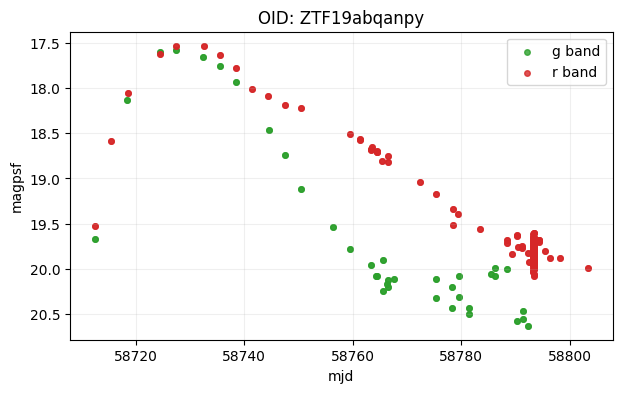

In [9]:
# curvas de luz
plot_lightcurve_scatter('ZTF19abqanpy', detecciones)

In [10]:
# fusión de documentos por oid
datos_fusionados = features_clean.merge(
    matches[['oid', 'classALeRCE']],
    on='oid', how='left'
)

# filtrar supernovas, incluyendo SN y SLSN
datos_supernovas = datos_fusionados[
    (datos_fusionados['classALeRCE'].str.startswith('SN', na=False)) |
    (datos_fusionados['classALeRCE'] == 'SLSN')
].copy()

In [11]:
# importamos la librería para usar balanced random forest
!pip install imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier

In [12]:
# importamos librerias para dividir la base de datos
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [13]:
X = datos_supernovas.drop(columns=['oid', 'classALeRCE'])
Y = datos_supernovas['classALeRCE']

X = X.fillna(-999)

print(f"Dimensiones de X (Características): {X.shape}")
print(f"Dimensiones de Y (Etiquetas): {Y.shape}")

Dimensiones de X (Características): (1823, 178)
Dimensiones de Y (Etiquetas): (1823,)


In [14]:
# dividimos en 70% y 30%
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=42,
    stratify=Y
)

# dividimos el 30% en 15% y 15%
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp,
    Y_temp,
    test_size=0.5,
    random_state=42,
    stratify=Y_temp
)

# mostramos dimensiones
print("\n--- Distribución de los Conjuntos ---")
print(f"Entrenamiento (70%): X={X_train.shape}, Y={Y_train.shape}")
print(f"Validación (15%): X={X_val.shape}, Y={Y_val.shape}")
print(f"Test (15%): X={X_test.shape}, Y={Y_test.shape}")


--- Distribución de los Conjuntos ---
Entrenamiento (70%): X=(1276, 178), Y=(1276,)
Validación (15%): X=(273, 178), Y=(273,)
Test (15%): X=(274, 178), Y=(274,)


## **Entrenamiento del Balanced Random Forest**

In [15]:
# entrenamiento del Balanced Random Forest
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    sampling_strategy='auto',
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando Balanced Random Forest con imputación -999...")
brf.fit(X_train, Y_train)
print("Entrenamiento completado.")

print("\nEntrenando Balanced Random Forest con imputación -999...")
brf.fit(X_train, Y_train)
print("Entrenamiento completado.")

# Evaluación inicial
Y_pred_val = brf.predict(X_val)
print("\n--- Métricas en el Conjunto de Validación ---")
print(classification_report(Y_val, Y_pred_val))


Entrenando Balanced Random Forest con imputación -999...
Entrenamiento completado.

Entrenando Balanced Random Forest con imputación -999...
Entrenamiento completado.

--- Métricas en el Conjunto de Validación ---
              precision    recall  f1-score   support

        SLSN       0.27      0.75      0.40         4
        SNII       0.50      0.33      0.39        43
       SNIIb       0.05      1.00      0.09         3
       SNIIn       0.10      0.20      0.13         5
        SNIa       0.92      0.58      0.71       204
       SNIbc       0.16      0.36      0.22        14

    accuracy                           0.53       273
   macro avg       0.33      0.54      0.32       273
weighted avg       0.78      0.53      0.61       273



In [16]:
# importamos librerías para mostrar las matrices de confusión
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [17]:
def plot_normalized_confusion_matrix(Y_true, Y_pred, title, ax):
    """
    Genera y plotea la matriz de confusión normalizada.

    Y_true: Etiquetas verdaderas.
    Y_pred: Predicciones del modelo.
    title: Título para el gráfico.
    ax: Objeto Axes de Matplotlib para dibujar.
    """
    # Calcular la matriz de confusión
    cm = confusion_matrix(Y_true, Y_pred)

    # Normalizar la matriz (por fila, para obtener el Recall)
    # np.sum(axis=1) suma los elementos de cada fila
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Obtener las etiquetas de las clases
    class_labels = np.unique(Y_true)

    # Crear el mapa de calor (heatmap)
    sns.heatmap(
        cm_normalized,
        annot=True, # Mostrar los valores
        fmt=".2f", # Formato de 2 decimales
        cmap="Blues", # Mapa de color
        cbar=True, # Mostrar barra de color
        xticklabels=class_labels, # Etiquetas del eje X (Predichas)
        yticklabels=class_labels, # Etiquetas del eje Y (Verdaderas)
        ax=ax
    )

    # Configuración de títulos y etiquetas
    ax.set_title(title)
    ax.set_ylabel('Etiqueta Verdadera')
    ax.set_xlabel('Etiqueta Predicha')

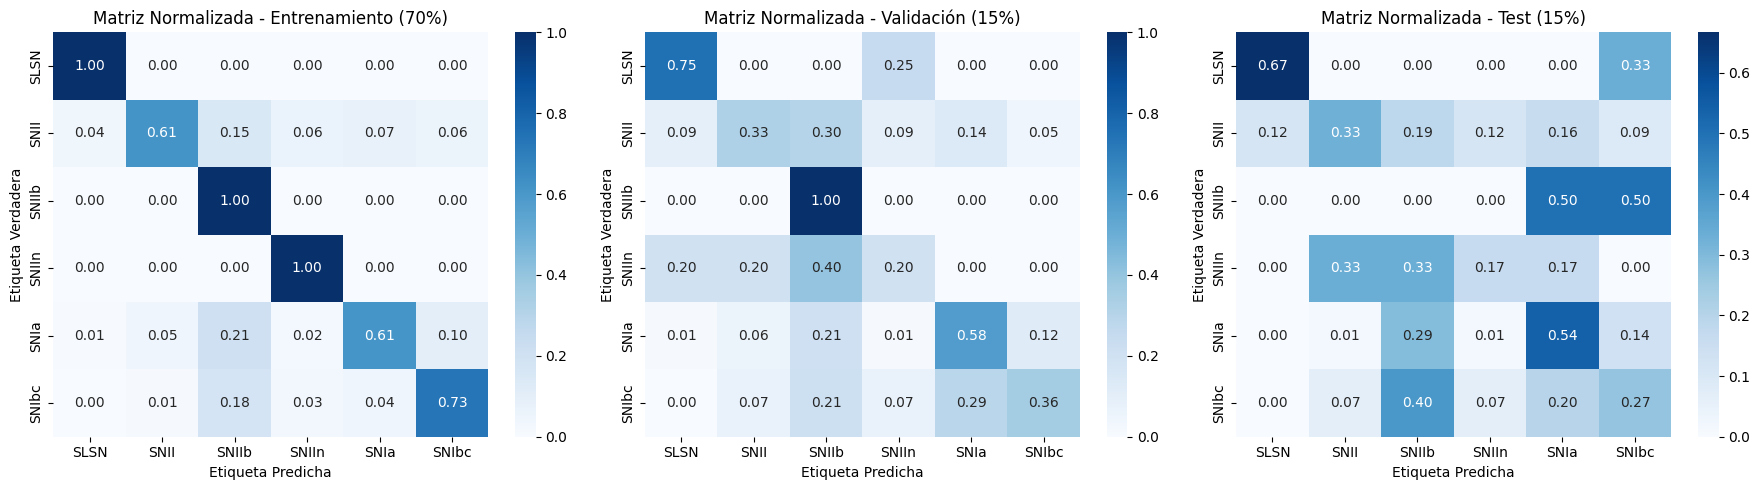

In [18]:
# 1. Obtener Predicciones

# Predicciones de Entrenamiento
Y_pred_train = brf.predict(X_train)

# Predicciones de Validación
# Y_pred_val = brf.predict(X_val)

# Predicciones de Test
Y_pred_test = brf.predict(X_test)


# 2. Crear la Figura y los Subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # 1 fila, 3 columnas

# 3. Plotear cada Matriz
# Matriz de Entrenamiento
plot_normalized_confusion_matrix(
    Y_train,
    Y_pred_train,
    title='Matriz Normalizada - Entrenamiento (70%)',
    ax=axes[0]
)

# Matriz de Validación
plot_normalized_confusion_matrix(
    Y_val,
    Y_pred_val,
    title='Matriz Normalizada - Validación (15%)',
    ax=axes[1]
)

# Matriz de Test
plot_normalized_confusion_matrix(
    Y_test,
    Y_pred_test,
    title='Matriz Normalizada - Test (15%)',
    ax=axes[2]
)

# Ajustar el layout y mostrar
plt.tight_layout()
plt.show()

## **Entrenamiento de la red MLP sin balanceo de datos**

In [19]:
# importamos librerías para la red MLP
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

In [20]:
class SupernovaDataset(Dataset):
    def __init__(self, X_data, Y_data):
        # Convertir datos de NumPy a Tensors de PyTorch
        # X_data debe ser de tipo float32
        # Y_data debe ser de tipo Long (entero)
        self.X_data = torch.from_numpy(X_data).float()
        self.Y_data = torch.from_numpy(Y_data).long()

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        return self.X_data[idx], self.Y_data[idx]

In [21]:
# Inicializar el escalador
scaler = StandardScaler()

# Ajustar el escalador SÓLO con los datos de entrenamiento
scaler.fit(X_train)

# Aplicar la transformación a los 3 conjuntos
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [22]:
# 1. Codificar etiquetas de texto a números (ej: 'SN Ia' -> 0, 'SN II' -> 1)
encoder = LabelEncoder()
Y_train_encoded = encoder.fit_transform(Y_train.to_numpy())
Y_val_encoded = encoder.transform(Y_val)
Y_test_encoded = encoder.transform(Y_test)

# Obtener las etiquetas de clase para el reporte final
class_names = encoder.classes_

# 2. Convertir los números a One-Hot Encoding (ej: 0 -> [1, 0, 0, ...])
Y_train_one_hot = to_categorical(Y_train_encoded)
Y_val_one_hot = to_categorical(Y_val_encoded)
Y_test_one_hot = to_categorical(Y_test_encoded)

# Número de clases de supernovas
num_classes = Y_train_one_hot.shape[1]
print(f"Número de clases de supernovas: {num_classes}")

Número de clases de supernovas: 6


In [23]:
# Crear las instancias de Dataset
train_dataset = SupernovaDataset(X_train_scaled, Y_train_encoded)
val_dataset = SupernovaDataset(X_val_scaled, Y_val_encoded)
test_dataset = SupernovaDataset(X_test_scaled, Y_test_encoded)

# Crear los DataLoaders (para iterar los datos en lotes)
BATCH_SIZE = 32

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        # Definir las capas secuencialmente
        self.layer_stack = nn.Sequential(
            # Capa de Entrada a Oculta 1
            nn.Linear(input_size, 128),
            nn.ReLU(),

            # Capa Oculta 1 a Oculta 2
            nn.Linear(128, 64),
            nn.ReLU(),

            # Capa Oculta 2 a Oculta 3
            nn.Linear(64, 32),
            nn.ReLU(),

            # Capa de Salida (no se usa softmax aquí, se aplica en la función de pérdida)
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        # El método forward define cómo fluye el dato a través de las capas
        logits = self.layer_stack(x)
        return logits

# Inicializar el modelo
INPUT_SIZE = X_train_scaled.shape[1]
NUM_CLASSES = num_classes # Obtenido en el paso de Keras/TensorFlow

model = MLPClassifier(input_size=INPUT_SIZE, num_classes=NUM_CLASSES)

# Imprimir la arquitectura del modelo
print(model)

MLPClassifier(
  (layer_stack): Sequential(
    (0): Linear(in_features=178, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [25]:
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_metrics(model, dataloader, criterion, device):
    """Calcula la pérdida y la precisión en un conjunto de datos."""
    model.eval() # Modo evaluación
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            # Pérdida
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            # Precisión
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [26]:
# Parámetros del experimento
N_EXPERIMENTS = 3  # Número de corridas de entrenamiento que deseas
N_EPOCHS = 15      # Número de épocas por corrida

# Listas para almacenar las métricas de todas las corridas
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []

# Configuraciones del modelo (mismas que antes)
INPUT_SIZE = X_train_scaled.shape[1]
NUM_CLASSES = num_classes # Asume que 'num_classes' está definido

print(f"Iniciando {N_EXPERIMENTS} experimentos de entrenamiento de la MLP (PyTorch)...")

for exp_run in range(N_EXPERIMENTS):
    print(f"\n--- Experimento {exp_run + 1}/{N_EXPERIMENTS} ---")

    # 1. Inicializar un nuevo modelo para cada corrida
    model = MLPClassifier(input_size=INPUT_SIZE, num_classes=NUM_CLASSES)
    model.to(device)

    # 2. Configurar optimizador y función de pérdida (nuevos para cada modelo)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Listas para guardar las métricas de la corrida actual
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 3. Ciclo de Entrenamiento
    for epoch in range(N_EPOCHS):
        # A. Paso de Entrenamiento (calcula y aplica gradientes)
        model.train()
        epoch_train_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)

        avg_train_loss = epoch_train_loss / len(train_loader.dataset)

        # B. Evaluación en Entrenamiento y Validación

        # Evaluación en entrenamiento (Para el accuracy de entrenamiento)
        _, train_acc = evaluate_metrics(model, train_loader, criterion, device)

        # Evaluación en validación
        avg_val_loss, val_acc = evaluate_metrics(model, val_loader, criterion, device)

        # 4. Guardar métricas de la época
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Opcional: imprimir el estado del entrenamiento
        if (epoch + 1) % 10 == 0:
            print(f'  Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # 5. Almacenar las listas de la corrida actual en las listas globales
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_accuracies.append(train_accuracies)
    all_val_accuracies.append(val_accuracies)

print("\n Todos los experimentos completados. Métricas almacenadas.")

Iniciando 3 experimentos de entrenamiento de la MLP (PyTorch)...

--- Experimento 1/3 ---
  Epoch 10/15 | Train Loss: 0.5331, Val Loss: 0.7441, Val Acc: 0.7985

--- Experimento 2/3 ---
  Epoch 10/15 | Train Loss: 0.5465, Val Loss: 0.7682, Val Acc: 0.7875

--- Experimento 3/3 ---
  Epoch 10/15 | Train Loss: 0.5522, Val Loss: 0.7344, Val Acc: 0.7985

 Todos los experimentos completados. Métricas almacenadas.



--- Métricas en el Conjunto de Test (PyTorch MLP) ---
              precision    recall  f1-score   support

        SLSN       0.00      0.00      0.00         3
        SNII       0.69      0.47      0.56        43
       SNIIb       0.00      0.00      0.00         2
       SNIIn       0.00      0.00      0.00         6
        SNIa       0.82      0.99      0.90       205
       SNIbc       0.00      0.00      0.00        15

    accuracy                           0.81       274
   macro avg       0.25      0.24      0.24       274
weighted avg       0.73      0.81      0.76       274



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


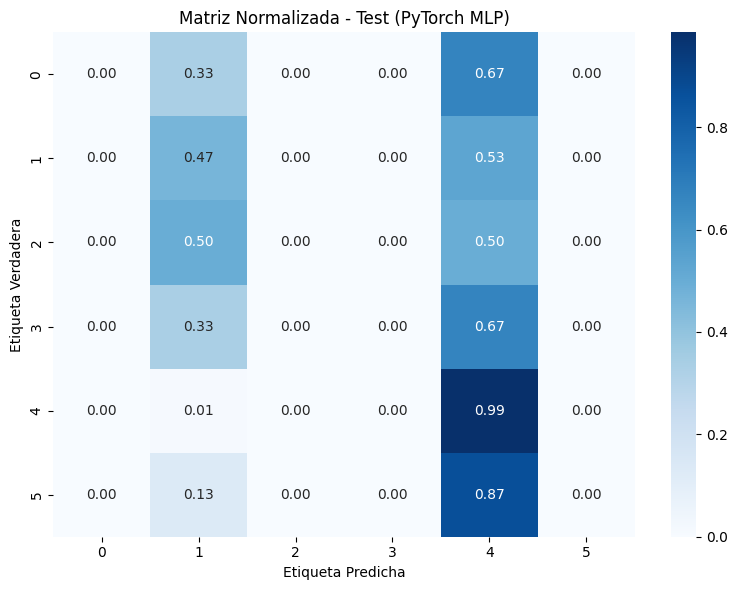

In [27]:
def evaluate_model(model, dataloader, device):
    model.eval() # Pone el modelo en modo evaluación
    Y_true = []
    Y_pred = []

    with torch.no_grad(): # Desactiva el cálculo de gradientes
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            # Obtener la clase predicha (índice con la mayor probabilidad)
            _, predicted = torch.max(outputs.data, 1)

            # Recolectar resultados
            Y_true.extend(labels.cpu().numpy())
            Y_pred.extend(predicted.cpu().numpy())

    return Y_true, Y_pred

# Obtener etiquetas verdaderas y predichas del conjunto de Test
Y_true_pytorch, Y_pred_pytorch = evaluate_model(model, test_loader, device)

# Reporte de Clasificación
print("\n--- Métricas en el Conjunto de Test (PyTorch MLP) ---")
print(classification_report(Y_true_pytorch, Y_pred_pytorch, target_names=class_names))


# Matriz de Confusión Normalizada
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# La función plot_normalized_confusion_matrix usa numpy arrays, así que usamos Y_true_pytorch/Y_pred_pytorch
# que ya están convertidos a numpy en la función evaluate_model.
plot_normalized_confusion_matrix(
    Y_true_pytorch,
    Y_pred_pytorch,
    title='Matriz Normalizada - Test (PyTorch MLP)',
    ax=ax
)


plt.tight_layout()
plt.show()

In [28]:
# Convertir las listas de listas a arrays de NumPy
# La forma (shape) será (N_EXPERIMENTS, N_EPOCHS)
np_train_losses = np.array(all_train_losses)
np_val_losses = np.array(all_val_losses)
np_train_accuracies = np.array(all_train_accuracies)
np_val_accuracies = np.array(all_val_accuracies)

# Calcular el promedio a través de los experimentos (eje 0)
# La forma resultante será (N_EPOCHS,)
mean_train_loss = np_train_losses.mean(axis=0)
mean_val_loss = np_val_losses.mean(axis=0)
mean_train_accuracy = np_train_accuracies.mean(axis=0)
mean_val_accuracy = np_val_accuracies.mean(axis=0)

# Opcional: Calcular la desviación estándar (STD) para visualizar la dispersión/estabilidad
std_val_loss = np_val_losses.std(axis=0)
std_val_accuracy = np_val_accuracies.std(axis=0)

# El rango de épocas para el eje X
epochs = np.arange(1, len(mean_train_loss) + 1)

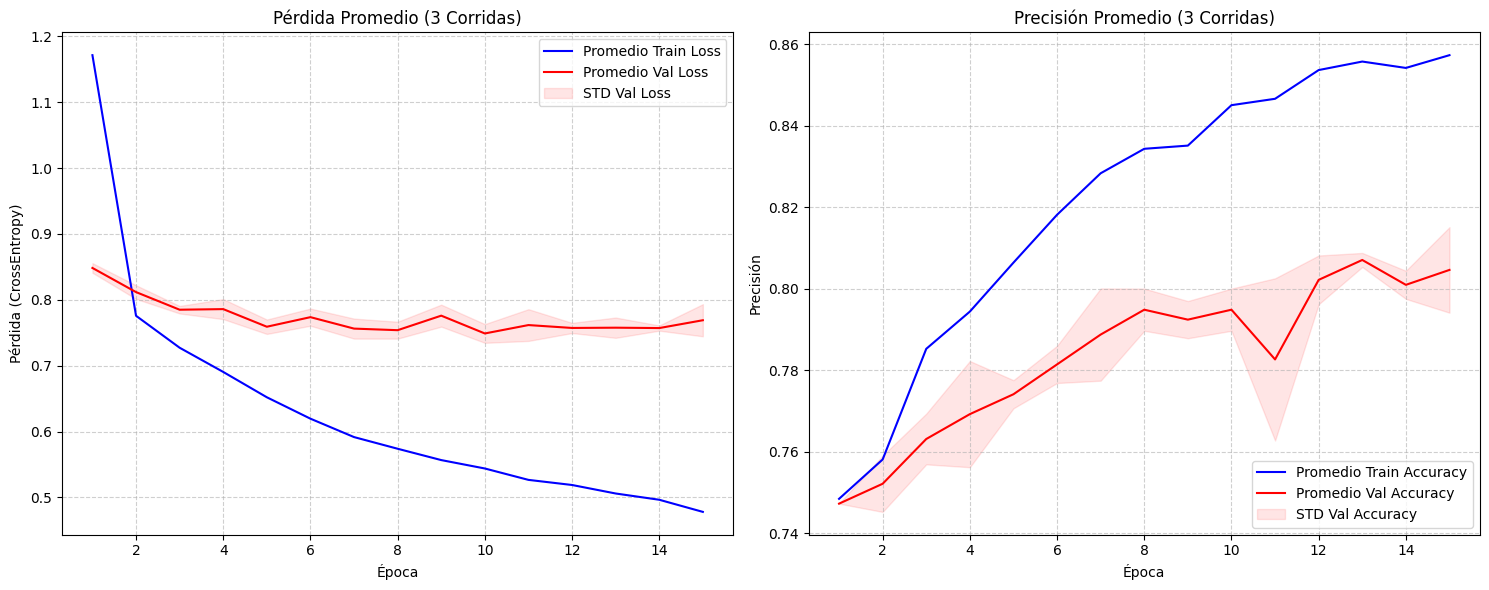

In [29]:
plt.figure(figsize=(15, 6))

# ------------------------------
# Gráfico 1: Pérdida Promedio (Loss)
# ------------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_train_loss, label='Promedio Train Loss', color='blue')
plt.plot(epochs, mean_val_loss, label='Promedio Val Loss', color='red')

# Rellenar el área de +/- 1 Desviación Estándar para la validación (para ver la estabilidad)
plt.fill_between(
    epochs,
    mean_val_loss - std_val_loss,
    mean_val_loss + std_val_loss,
    color='red',
    alpha=0.1,
    label='STD Val Loss'
)

plt.title(f'Pérdida Promedio ({N_EXPERIMENTS} Corridas)')
plt.xlabel('Época')
plt.ylabel('Pérdida (CrossEntropy)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# Gráfico 2: Precisión Promedio (Accuracy)
# ------------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_train_accuracy, label='Promedio Train Accuracy', color='blue')
plt.plot(epochs, mean_val_accuracy, label='Promedio Val Accuracy', color='red')

# Rellenar el área de +/- 1 Desviación Estándar para la validación
plt.fill_between(
    epochs,
    mean_val_accuracy - std_val_accuracy,
    mean_val_accuracy + std_val_accuracy,
    color='red',
    alpha=0.1,
    label='STD Val Accuracy'
)

plt.title(f'Precisión Promedio ({N_EXPERIMENTS} Corridas)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## **Entrenamiento de red MLP usando UNDERSAMPLING**

In [30]:
from imblearn.under_sampling import RandomUnderSampler

# Variables de entrada para el muestreo:
# X_train, Y_train (datos originales de entrenamiento, imputados con -999)

print("\n--- Aplicando Random Under-Sampler (RUS) a datos de Entrenamiento ---")
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_rus, Y_train_rus = rus.fit_resample(X_train, Y_train)

print(f"Dimensiones ANTES de RUS: {X_train.shape}")
print(f"Dimensiones DESPUÉS de RUS: {X_train_rus.shape}")
print(f"Distribución de clases DESPUÉS de RUS:\n{Y_train_rus.value_counts()}")


--- Aplicando Random Under-Sampler (RUS) a datos de Entrenamiento ---
Dimensiones ANTES de RUS: (1276, 178)
Dimensiones DESPUÉS de RUS: (66, 178)
Distribución de clases DESPUÉS de RUS:
classALeRCE
SLSN     11
SNII     11
SNIIb    11
SNIIn    11
SNIa     11
SNIbc    11
Name: count, dtype: int64


In [31]:
# Inicializar un nuevo escalador para este experimento RUS
scaler_rus = StandardScaler()

# 1. Ajustar (fit) el escalador SÓLO a los datos de entrenamiento balanceados (RUS)
scaler_rus.fit(X_train_rus)

# 2. Aplicar la transformación a los 3 conjuntos:
X_train_scaled_rus = scaler_rus.transform(X_train_rus) # ¡Datos de entrenamiento BALANCEADOS!
X_val_scaled_rus = scaler_rus.transform(X_val)         # Validación (original)
X_test_scaled_rus = scaler_rus.transform(X_test)       # Test (original)

In [32]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# NOTA: Debemos usar el mismo 'encoder' si ya lo definiste y ajustaste para el experimento anterior
# Si no, deberás definirlo y ajustarlo aquí, pero es mejor usar el mismo si es posible.

# Asumiendo que 'encoder' YA FUE AJUSTADO (fit) con las etiquetas originales (Y_train)
# en tu primer experimento de MLP. Si fue así, solo necesitas transformarlo.

print("\n--- Codificando Etiquetas Y para el Experimento RUS ---")

# 1. Codificar etiquetas de texto a números (solo transformamos, no ajustamos de nuevo)
# Usamos .to_numpy() si Y_train_rus/Y_val/Y_test siguen siendo Series de Pandas.

Y_train_encoded_rus = encoder.transform(Y_train_rus.to_numpy())
Y_val_encoded_rus = encoder.transform(Y_val.to_numpy())
Y_test_encoded_rus = encoder.transform(Y_test.to_numpy())

# 'class_names' y 'num_classes' NO necesitan redefinirse, ya que el encoder es el mismo.
# class_names = encoder.classes_
# num_classes = Y_train_one_hot.shape[1]

# 2. Convertir los números a One-Hot Encoding
Y_train_one_hot_rus = to_categorical(Y_train_encoded_rus)
Y_val_one_hot_rus = to_categorical(Y_val_encoded_rus)
Y_test_one_hot_rus = to_categorical(Y_test_encoded_rus)

print("Etiquetas codificadas para el experimento RUS.")
print(f"Dimensiones Y_train_one_hot_rus: {Y_train_one_hot_rus.shape}")


--- Codificando Etiquetas Y para el Experimento RUS ---
Etiquetas codificadas para el experimento RUS.
Dimensiones Y_train_one_hot_rus: (66, 6)


In [33]:
# 1. Crear las instancias de Dataset (RUS)
# X_train_scaled_rus (float) y Y_train_encoded_rus (long/int)
train_dataset_rus = SupernovaDataset(X_train_scaled_rus, Y_train_encoded_rus)
val_dataset_rus = SupernovaDataset(X_val_scaled_rus, Y_val_encoded_rus)
test_dataset_rus = SupernovaDataset(X_test_scaled_rus, Y_test_encoded_rus)

# 2. Crear los DataLoaders (RUS)
BATCH_SIZE = 32

train_loader_rus = DataLoader(dataset=train_dataset_rus, batch_size=BATCH_SIZE, shuffle=True)
val_loader_rus = DataLoader(dataset=val_dataset_rus, batch_size=BATCH_SIZE, shuffle=False)
test_loader_rus = DataLoader(dataset=test_dataset_rus, batch_size=BATCH_SIZE, shuffle=False)

print("PyTorch DataLoaders para el experimento RUS creados.")

PyTorch DataLoaders para el experimento RUS creados.


In [34]:
# CÓDIGO A AGREGAR EN LA SECCIÓN DEL EXPERIMENTO RUS

# Dimensiones de entrada: se usan los datos balanceados y escalados por RUS
INPUT_SIZE_RUS = X_train_scaled_rus.shape[1]
# El número de clases (num_classes) es el mismo que en el experimento anterior

# Inicializar un nuevo modelo para esta corrida (crucial para evitar overfitting)
# Se usa la misma arquitectura, pero con un nombre de variable diferente
model_rus = MLPClassifier(input_size=INPUT_SIZE_RUS, num_classes=num_classes)

# Imprimir la arquitectura del nuevo modelo
print("\n--- Arquitectura del Modelo MLP (RUS) ---")
print(model_rus)

# 2. Configurar función de pérdida y optimizador para el nuevo modelo
criterion_rus = nn.CrossEntropyLoss()
optimizer_rus = optim.Adam(model_rus.parameters(), lr=0.001)

# Mover el modelo a la GPU/CPU
model_rus.to(device)

print("Modelo MLP para experimento RUS inicializado.")


--- Arquitectura del Modelo MLP (RUS) ---
MLPClassifier(
  (layer_stack): Sequential(
    (0): Linear(in_features=178, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=6, bias=True)
  )
)
Modelo MLP para experimento RUS inicializado.


In [35]:
# Parámetros del experimento (N_EXPERIMENTS y N_EPOCHS ya deben estar definidos)
N_EXPERIMENTS = 3
N_EPOCHS = 50

# Listas para almacenar las métricas de todas las corridas RUS
all_train_losses_rus = []    # ¡Nuevo sufijo!
all_val_losses_rus = []      # ¡Nuevo sufijo!
all_train_accuracies_rus = []# ¡Nuevo sufijo!
all_val_accuracies_rus = []  # ¡Nuevo sufijo!

# Las dimensiones y num_classes ya están definidas globalmente o como INPUT_SIZE_RUS

print(f"\nIniciando {N_EXPERIMENTS} experimentos de entrenamiento de la MLP con RUS (PyTorch)...")

for exp_run in range(N_EXPERIMENTS):
    print(f"\n--- Experimento RUS {exp_run + 1}/{N_EXPERIMENTS} ---")

    # 1. Inicializar un nuevo modelo para cada corrida (usamos la definición anterior)
    #  Se usa el INPUT_SIZE_RUS definido previamente
    model_rus = MLPClassifier(input_size=INPUT_SIZE_RUS, num_classes=num_classes)
    model_rus.to(device)

    # 2. Configurar optimizador y función de pérdida (nuevos para cada modelo)
    criterion_rus = nn.CrossEntropyLoss()
    optimizer_rus = optim.Adam(model_rus.parameters(), lr=0.001)

    # Listas para guardar las métricas de la corrida actual
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 3. Ciclo de Entrenamiento
    for epoch in range(N_EPOCHS):
        # A. Paso de Entrenamiento (calcula y aplica gradientes)
        model_rus.train() #  Usamos el nuevo modelo
        epoch_train_loss = 0.0

        # Usamos el DataLoader balanceado por RUS
        for inputs, labels in train_loader_rus:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_rus.zero_grad()
            outputs = model_rus(inputs)
            loss = criterion_rus(outputs, labels)
            loss.backward()
            optimizer_rus.step()
            epoch_train_loss += loss.item() * inputs.size(0)

        # Usamos la longitud del dataset RUS
        avg_train_loss = epoch_train_loss / len(train_loader_rus.dataset)

        # B. Evaluación en Entrenamiento y Validación

        # Evaluación en entrenamiento (usamos el DataLoader RUS)
        _, train_acc = evaluate_metrics(model_rus, train_loader_rus, criterion_rus, device)

        # Evaluación en validación (usamos el DataLoader de validación RUS)
        # Usamos val_loader_rus (el conjunto de validación NO está balanceado)
        avg_val_loss, val_acc = evaluate_metrics(model_rus, val_loader_rus, criterion_rus, device)

        # 4. Guardar métricas de la época
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Opcional: imprimir el estado del entrenamiento
        if (epoch + 1) % 10 == 0:
            print(f'  Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # 5. Almacenar las listas de la corrida actual en las listas globales RUS
    all_train_losses_rus.append(train_losses)
    all_val_losses_rus.append(val_losses)
    all_train_accuracies_rus.append(train_accuracies)
    all_val_accuracies_rus.append(val_accuracies)

print("\n Experimentos MLP con RUS completados. Métricas almacenadas.")


Iniciando 3 experimentos de entrenamiento de la MLP con RUS (PyTorch)...

--- Experimento RUS 1/3 ---
  Epoch 10/50 | Train Loss: 1.5941, Val Loss: 20.6520, Val Acc: 0.0623
  Epoch 20/50 | Train Loss: 1.1022, Val Loss: 29.2643, Val Acc: 0.4725
  Epoch 30/50 | Train Loss: 0.6948, Val Loss: 83.7811, Val Acc: 0.5128
  Epoch 40/50 | Train Loss: 0.3314, Val Loss: 132.3702, Val Acc: 0.3004
  Epoch 50/50 | Train Loss: 0.1289, Val Loss: 169.8052, Val Acc: 0.2784

--- Experimento RUS 2/3 ---
  Epoch 10/50 | Train Loss: 1.6053, Val Loss: 29.5966, Val Acc: 0.1941
  Epoch 20/50 | Train Loss: 1.1377, Val Loss: 101.9352, Val Acc: 0.2747
  Epoch 30/50 | Train Loss: 0.6826, Val Loss: 175.9895, Val Acc: 0.4286
  Epoch 40/50 | Train Loss: 0.3199, Val Loss: 301.2004, Val Acc: 0.2821
  Epoch 50/50 | Train Loss: 0.1179, Val Loss: 492.0383, Val Acc: 0.3114

--- Experimento RUS 3/3 ---
  Epoch 10/50 | Train Loss: 1.5742, Val Loss: 46.9916, Val Acc: 0.0769
  Epoch 20/50 | Train Loss: 1.0763, Val Loss: 84.212


--- Métricas en el Conjunto de Test (PyTorch MLP con RUS) ---
              precision    recall  f1-score   support

        SLSN       0.00      0.00      0.00         3
        SNII       0.40      0.19      0.25        43
       SNIIb       0.00      0.00      0.00         2
       SNIIn       0.00      0.00      0.00         6
        SNIa       0.85      0.40      0.55       205
       SNIbc       0.10      0.27      0.15        15

    accuracy                           0.35       274
   macro avg       0.22      0.14      0.16       274
weighted avg       0.70      0.35      0.46       274



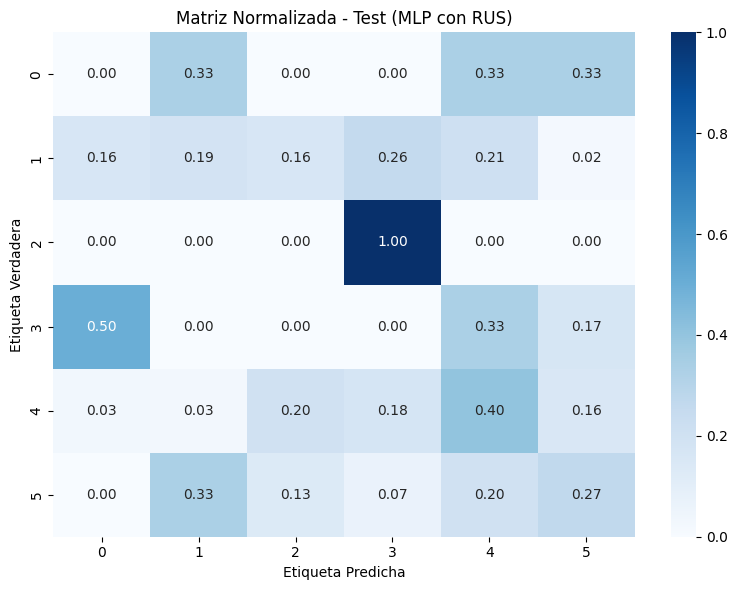

In [36]:
# Nota: La última instancia entrenada del modelo RUS está en 'model_rus'.
#       La función 'evaluate_model' debe estar definida en tu notebook.

# 1. Obtener etiquetas verdaderas y predichas del conjunto de Test
# Usamos el último modelo entrenado (model_rus) y el DataLoader de Test (test_loader_rus)
Y_true_pytorch_rus, Y_pred_pytorch_rus = evaluate_model(model_rus, test_loader_rus, device)

# 2. Reporte de Clasificación
print("\n--- Métricas en el Conjunto de Test (PyTorch MLP con RUS) ---")
# Usamos los nombres de clase ('class_names') para el reporte
print(classification_report(Y_true_pytorch_rus, Y_pred_pytorch_rus, target_names=class_names))


# 3. Matriz de Confusión Normalizada
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_normalized_confusion_matrix(
    Y_true_pytorch_rus,  # Etiquetas verdaderas numéricas (RUS)
    Y_pred_pytorch_rus,  # Predicciones numéricas (RUS)
    title='Matriz Normalizada - Test (MLP con RUS)', # 🎉 Usamos los nombres de clase
    ax=ax
)

plt.tight_layout()
plt.show()

# Opcional: Para guardar el último modelo entrenado (el que se evaluó):
# torch.save(model_rus.state_dict(), 'mlp_model_rus_final.pt')

In [37]:
# 1. Convertir las listas de listas del experimento RUS a arrays de NumPy
# Se asume que todas las listas (all_train_losses_rus, etc.) tienen la misma longitud (N_EPOCHS)
np_train_losses_rus = np.array(all_train_losses_rus)
np_val_losses_rus = np.array(all_val_losses_rus)
np_train_accuracies_rus = np.array(all_train_accuracies_rus)
np_val_accuracies_rus = np.array(all_val_accuracies_rus)

# 2. Calcular el promedio a través de los experimentos (eje 0)
# Las nuevas variables usan el sufijo _rus.
mean_train_loss_rus = np_train_losses_rus.mean(axis=0)
mean_val_loss_rus = np_val_losses_rus.mean(axis=0)
mean_train_accuracy_rus = np_train_accuracies_rus.mean(axis=0)
mean_val_accuracy_rus = np_val_accuracies_rus.mean(axis=0)

# 3. Calcular la desviación estándar (STD) para el área sombreada
std_val_loss_rus = np_val_losses_rus.std(axis=0)
std_val_accuracy_rus = np_val_accuracies_rus.std(axis=0)

# 4. El rango de épocas para el eje X
epochs_rus = np.arange(1, len(mean_train_loss_rus) + 1)

print("Métricas promedio RUS calculadas y listas para graficar.")

Métricas promedio RUS calculadas y listas para graficar.


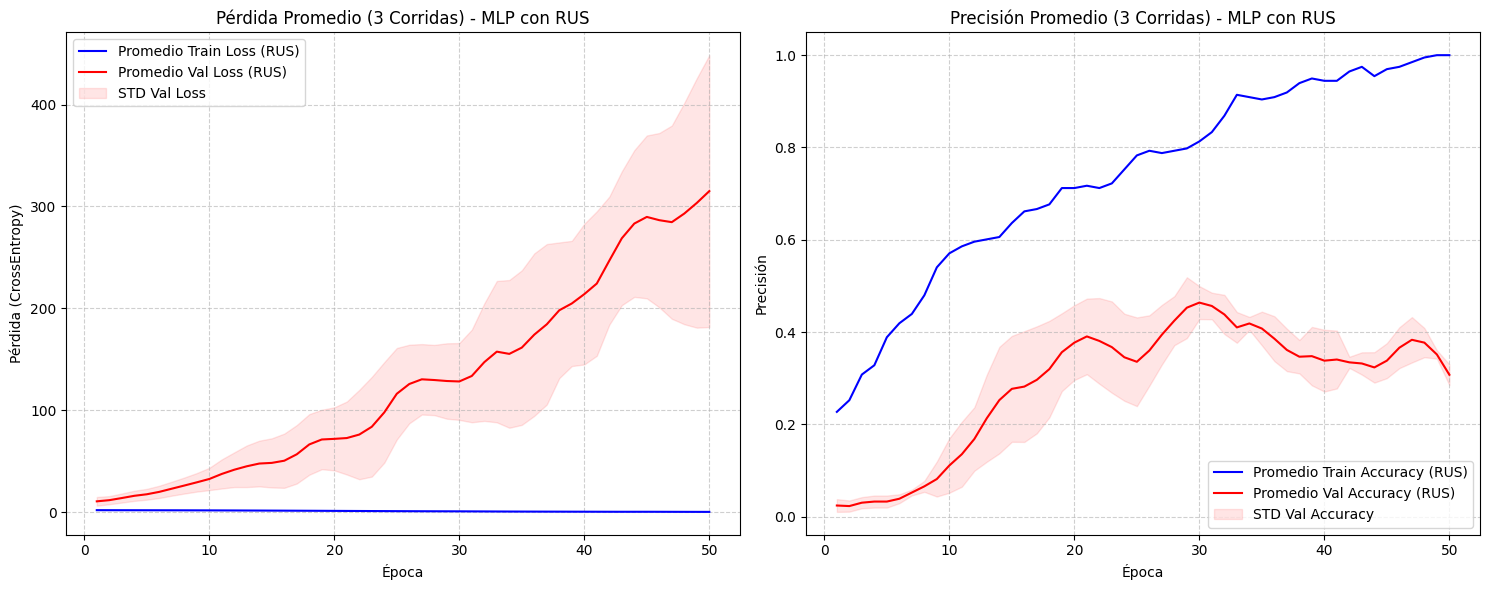

In [38]:
# N_EXPERIMENTS ya debe estar definido (e.g., N_EXPERIMENTS = 3)

plt.figure(figsize=(15, 6))

# ------------------------------
# Gráfico 1: Pérdida Promedio (Loss) con RUS
# ------------------------------
plt.subplot(1, 2, 1)
# Usamos las variables con sufijo _rus
plt.plot(epochs_rus, mean_train_loss_rus, label='Promedio Train Loss (RUS)', color='blue')
plt.plot(epochs_rus, mean_val_loss_rus, label='Promedio Val Loss (RUS)', color='red')

# Rellenar el área de +/- 1 Desviación Estándar para la validación
plt.fill_between(
    epochs_rus,
    mean_val_loss_rus - std_val_loss_rus,
    mean_val_loss_rus + std_val_loss_rus,
    color='red',
    alpha=0.1,
    label='STD Val Loss'
)

plt.title(f'Pérdida Promedio ({N_EXPERIMENTS} Corridas) - MLP con RUS')
plt.xlabel('Época')
plt.ylabel('Pérdida (CrossEntropy)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# Gráfico 2: Precisión Promedio (Accuracy) con RUS
# ------------------------------
plt.subplot(1, 2, 2)
# Usamos las variables con sufijo _rus
plt.plot(epochs_rus, mean_train_accuracy_rus, label='Promedio Train Accuracy (RUS)', color='blue')
plt.plot(epochs_rus, mean_val_accuracy_rus, label='Promedio Val Accuracy (RUS)', color='red')

# Rellenar el área de +/- 1 Desviación Estándar para la validación
plt.fill_between(
    epochs_rus,
    mean_val_accuracy_rus - std_val_accuracy_rus,
    mean_val_accuracy_rus + std_val_accuracy_rus,
    color='red',
    alpha=0.1,
    label='STD Val Accuracy'
)

plt.title(f'Precisión Promedio ({N_EXPERIMENTS} Corridas) - MLP con RUS')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## **Entrenamiento de red MLP usando SMOTEENN**

In [39]:
from imblearn.combine import SMOTEENN

print("\n--- Aplicando SMOTEENN a datos de Entrenamiento ---")

# 1. Inicializar el muestreador combinado
# SMOTEENN aplica SMOTE (sobremuestreo) y luego Edited Nearest Neighbours (ENN) para limpiar el ruido.
smoteen = SMOTEENN(random_state=42)

# 2. Aplicar SMOTEENN al conjunto de entrenamiento
# Nota: Y_train.to_numpy() se usa para asegurar que es un array 1D
X_train_smoteen, Y_train_smoteen = smoteen.fit_resample(X_train, Y_train.to_numpy())

print(f"Dimensiones de X_train después de SMOTEENN: {X_train_smoteen.shape}")
print(f"Distribución de clases después de SMOTEENN:\n{pd.Series(Y_train_smoteen).value_counts()}")

# 3. Estandarización de Características (X)
# Inicializar un nuevo escalador para este experimento SMOTEENN
scaler_smoteen = StandardScaler()

# Ajustar el escalador SÓLO con los datos de entrenamiento BALANCEADOS por SMOTEENN
scaler_smoteen.fit(X_train_smoteen)

# Aplicar la transformación a los 3 conjuntos:
X_train_scaled_smoteen = scaler_smoteen.transform(X_train_smoteen)
X_val_scaled_smoteen = scaler_smoteen.transform(X_val)
X_test_scaled_smoteen = scaler_smoteen.transform(X_test)

# 4. Codificación de Etiquetas (Y)
# Usamos el 'encoder' ya ajustado en el experimento original
Y_train_encoded_smoteen = encoder.transform(Y_train_smoteen)
Y_val_encoded_smoteen = encoder.transform(Y_val.to_numpy())
Y_test_encoded_smoteen = encoder.transform(Y_test.to_numpy())

# 5. One-Hot Encoding (si es necesario para Keras/Pytorch)
Y_train_one_hot_smoteen = to_categorical(Y_train_encoded_smoteen)
Y_val_one_hot_smoteen = to_categorical(Y_val_encoded_smoteen)
Y_test_one_hot_smoteen = to_categorical(Y_test_encoded_smoteen)


--- Aplicando SMOTEENN a datos de Entrenamiento ---
Dimensiones de X_train después de SMOTEENN: (4361, 178)
Distribución de clases después de SMOTEENN:
SNIIb    887
SLSN     845
SNIIn    815
SNIbc    774
SNII     649
SNIa     391
Name: count, dtype: int64


In [40]:
# Crear las instancias de Dataset (SMOTEENN)
train_dataset_smoteen = SupernovaDataset(X_train_scaled_smoteen, Y_train_encoded_smoteen)
val_dataset_smoteen = SupernovaDataset(X_val_scaled_smoteen, Y_val_encoded_smoteen)
test_dataset_smoteen = SupernovaDataset(X_test_scaled_smoteen, Y_test_encoded_smoteen)

# Crear los DataLoaders (SMOTEENN)
BATCH_SIZE = 32

train_loader_smoteen = DataLoader(dataset=train_dataset_smoteen, batch_size=BATCH_SIZE, shuffle=True)
val_loader_smoteen = DataLoader(dataset=val_dataset_smoteen, batch_size=BATCH_SIZE, shuffle=False)
test_loader_smoteen = DataLoader(dataset=test_dataset_smoteen, batch_size=BATCH_SIZE, shuffle=False)

print("PyTorch DataLoaders para el experimento SMOTEENN creados.")

PyTorch DataLoaders para el experimento SMOTEENN creados.


In [41]:
# Usamos las dimensiones del nuevo conjunto de entrenamiento balanceado
INPUT_SIZE_SMOTEEN = X_train_scaled_smoteen.shape[1]
# NUM_CLASSES es el mismo

# Inicializar listas para almacenar las métricas
all_train_losses_smoteen = []
all_val_losses_smoteen = []
all_train_accuracies_smoteen = []
all_val_accuracies_smoteen = []

# Inicializar el modelo
model_smoteen = MLPClassifier(input_size=INPUT_SIZE_SMOTEEN, num_classes=num_classes)
model_smoteen.to(device)

print("\n--- Modelo MLP para experimento SMOTEENN inicializado. ---")


--- Modelo MLP para experimento SMOTEENN inicializado. ---


In [42]:
# N_EXPERIMENTS y N_EPOCHS ya deben estar definidos
N_EXPERIMENTS = 3
N_EPOCHS = 50

print(f"\nIniciando {N_EXPERIMENTS} experimentos de entrenamiento de la MLP con SMOTEENN...")

for exp_run in range(N_EXPERIMENTS):
    print(f"\n--- Experimento SMOTEENN {exp_run + 1}/{N_EXPERIMENTS} ---")

    # 1. Inicializar un nuevo modelo para cada corrida
    model_smoteen_run = MLPClassifier(input_size=INPUT_SIZE_SMOTEEN, num_classes=num_classes)
    model_smoteen_run.to(device)

    # 2. Configurar optimizador y función de pérdida
    criterion_smoteen = nn.CrossEntropyLoss()
    optimizer_smoteen = optim.Adam(model_smoteen_run.parameters(), lr=0.001)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 3. Ciclo de Entrenamiento
    for epoch in range(N_EPOCHS):
        model_smoteen_run.train()
        epoch_train_loss = 0.0

        # Usamos train_loader_smoteen
        for inputs, labels in train_loader_smoteen:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer_smoteen.zero_grad()
            outputs = model_smoteen_run(inputs)
            loss = criterion_smoteen(outputs, labels)
            loss.backward()
            optimizer_smoteen.step()
            epoch_train_loss += loss.item() * inputs.size(0)

        avg_train_loss = epoch_train_loss / len(train_loader_smoteen.dataset)

        # Evaluación en entrenamiento (usamos train_loader_smoteen)
        _, train_acc = evaluate_metrics(model_smoteen_run, train_loader_smoteen, criterion_smoteen, device)

        # Evaluación en validación (usamos val_loader_smoteen)
        avg_val_loss, val_acc = evaluate_metrics(model_smoteen_run, val_loader_smoteen, criterion_smoteen, device)

        # 4. Guardar métricas de la época
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Opcional: imprimir el estado del entrenamiento
        if (epoch + 1) % 10 == 0:
            print(f'  Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # 5. Almacenar las listas de la corrida actual en las listas globales
    all_train_losses_smoteen.append(train_losses)
    all_val_losses_smoteen.append(val_losses)
    all_train_accuracies_smoteen.append(train_accuracies)
    all_val_accuracies_smoteen.append(val_accuracies)

print("\n Experimentos MLP con SMOTEENN completados. Métricas almacenadas.")


Iniciando 3 experimentos de entrenamiento de la MLP con SMOTEENN...

--- Experimento SMOTEENN 1/3 ---
  Epoch 10/50 | Train Loss: 0.1064, Val Loss: 2.8835, Val Acc: 0.5495
  Epoch 20/50 | Train Loss: 0.0296, Val Loss: 3.8162, Val Acc: 0.6374
  Epoch 30/50 | Train Loss: 0.0163, Val Loss: 5.0528, Val Acc: 0.5568
  Epoch 40/50 | Train Loss: 0.0313, Val Loss: 5.8487, Val Acc: 0.6264
  Epoch 50/50 | Train Loss: 0.0004, Val Loss: 7.0822, Val Acc: 0.6154

--- Experimento SMOTEENN 2/3 ---
  Epoch 10/50 | Train Loss: 0.0991, Val Loss: 3.0070, Val Acc: 0.5275
  Epoch 20/50 | Train Loss: 0.0271, Val Loss: 4.5010, Val Acc: 0.6227
  Epoch 30/50 | Train Loss: 0.0278, Val Loss: 5.7502, Val Acc: 0.5604
  Epoch 40/50 | Train Loss: 0.0015, Val Loss: 6.4759, Val Acc: 0.5971
  Epoch 50/50 | Train Loss: 0.0019, Val Loss: 7.2127, Val Acc: 0.5971

--- Experimento SMOTEENN 3/3 ---
  Epoch 10/50 | Train Loss: 0.0899, Val Loss: 3.4321, Val Acc: 0.5751
  Epoch 20/50 | Train Loss: 0.0506, Val Loss: 4.8430, Val A

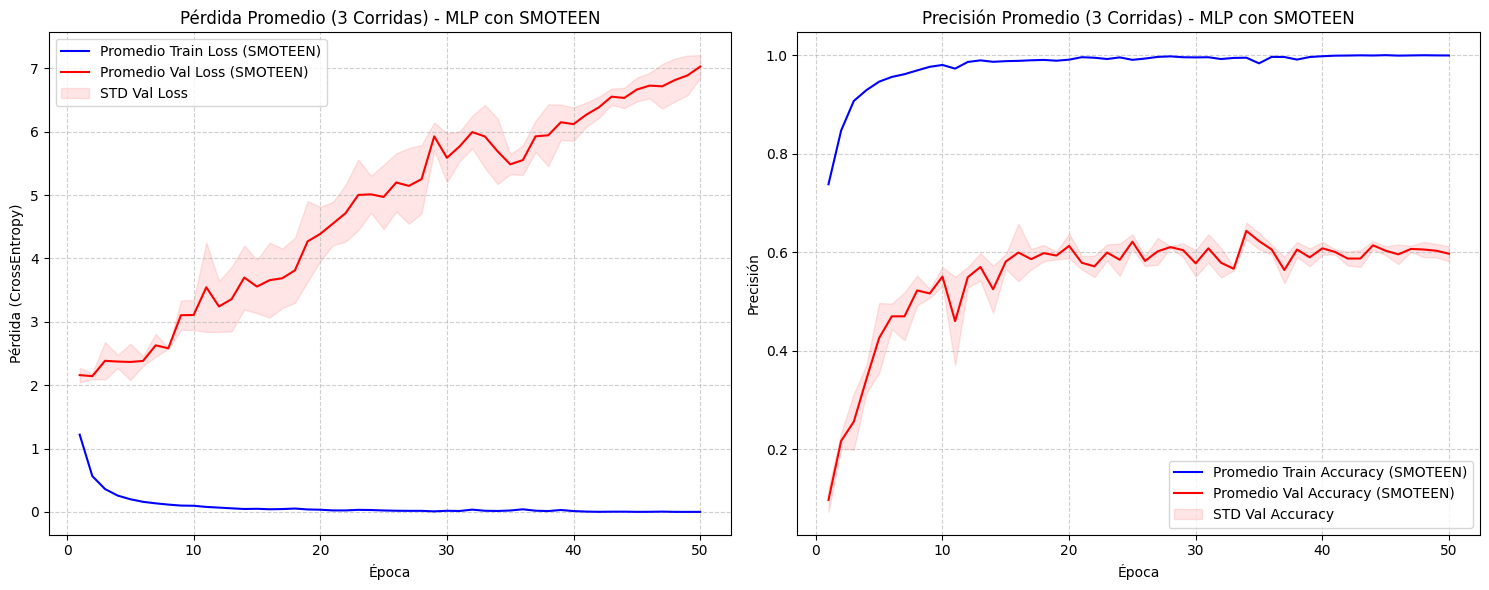

In [43]:
# 1. Convertir a NumPy y calcular el promedio (asumiendo que las longitudes son iguales)
np_train_losses_smoteen = np.array(all_train_losses_smoteen)
np_val_losses_smoteen = np.array(all_val_losses_smoteen)
np_train_accuracies_smoteen = np.array(all_train_accuracies_smoteen)
np_val_accuracies_smoteen = np.array(all_val_accuracies_smoteen)

mean_train_loss_smoteen = np_train_losses_smoteen.mean(axis=0)
mean_val_loss_smoteen = np_val_losses_smoteen.mean(axis=0)
mean_train_accuracy_smoteen = np_train_accuracies_smoteen.mean(axis=0)
mean_val_accuracy_smoteen = np_val_accuracies_smoteen.mean(axis=0)

std_val_loss_smoteen = np_val_losses_smoteen.std(axis=0)
std_val_accuracy_smoteen = np_val_accuracies_smoteen.std(axis=0)

epochs_smoteen = np.arange(1, len(mean_train_loss_smoteen) + 1)

# 2. Generar Gráfico de Curvas Promedio
plt.figure(figsize=(15, 6))

# ------------------------------
# Gráfico 1: Pérdida Promedio (Loss) con RUS
# ------------------------------
plt.subplot(1, 2, 1)
# Usamos las variables con sufijo _rus
plt.plot(epochs_smoteen, mean_train_loss_smoteen, label='Promedio Train Loss (SMOTEEN)', color='blue')
plt.plot(epochs_smoteen, mean_val_loss_smoteen, label='Promedio Val Loss (SMOTEEN)', color='red')

# Rellenar el área de +/- 1 Desviación Estándar para la validación
plt.fill_between(
    epochs_smoteen,
    mean_val_loss_smoteen - std_val_loss_smoteen,
    mean_val_loss_smoteen + std_val_loss_smoteen,
    color='red',
    alpha=0.1,
    label='STD Val Loss'
)

plt.title(f'Pérdida Promedio ({N_EXPERIMENTS} Corridas) - MLP con SMOTEEN')
plt.xlabel('Época')
plt.ylabel('Pérdida (CrossEntropy)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# ------------------------------
# Gráfico 2: Precisión Promedio (Accuracy) con RUS
# ------------------------------
plt.subplot(1, 2, 2)
# Usamos las variables con sufijo _rus
plt.plot(epochs_smoteen, mean_train_accuracy_smoteen, label='Promedio Train Accuracy (SMOTEEN)', color='blue')
plt.plot(epochs_smoteen, mean_val_accuracy_smoteen, label='Promedio Val Accuracy (SMOTEEN)', color='red')

# Rellenar el área de +/- 1 Desviación Estándar para la validación
plt.fill_between(
    epochs_smoteen,
    mean_val_accuracy_smoteen - std_val_accuracy_smoteen,
    mean_val_accuracy_smoteen + std_val_accuracy_smoteen,
    color='red',
    alpha=0.1,
    label='STD Val Accuracy'
)

plt.title(f'Precisión Promedio ({N_EXPERIMENTS} Corridas) - MLP con SMOTEEN')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


--- Métricas en el Conjunto de Test (PyTorch MLP con SMOTEENN) ---
              precision    recall  f1-score   support

        SLSN       0.00      0.00      0.00         3
        SNII       0.41      0.56      0.48        43
       SNIIb       0.00      0.00      0.00         2
       SNIIn       0.00      0.00      0.00         6
        SNIa       0.83      0.67      0.74       205
       SNIbc       0.06      0.13      0.08        15

    accuracy                           0.60       274
   macro avg       0.22      0.23      0.22       274
weighted avg       0.69      0.60      0.64       274



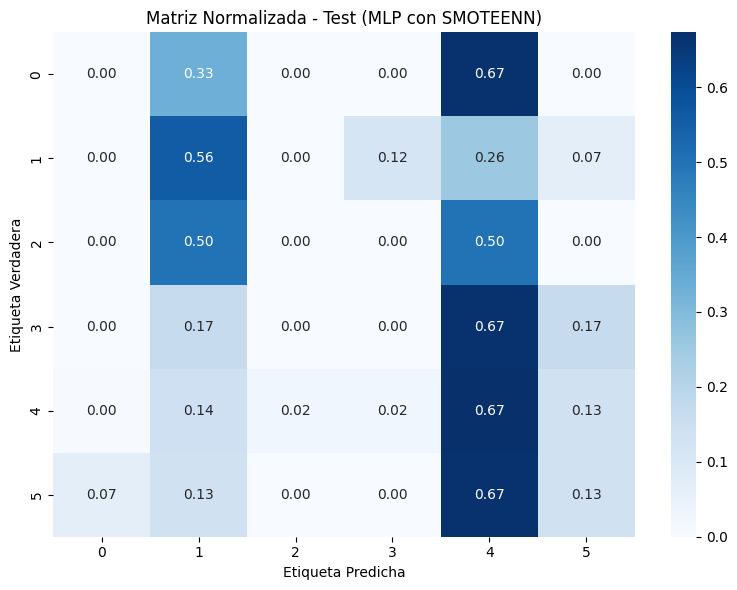

In [44]:
# La última instancia entrenada del modelo SMOTEENN está en 'model_smoteen_run'.
# Usamos el DataLoader de Test (test_loader_smoteen)
Y_true_pytorch_smoteen, Y_pred_pytorch_smoteen = evaluate_model(model_smoteen_run, test_loader_smoteen, device)

# Reporte de Clasificación
print("\n--- Métricas en el Conjunto de Test (PyTorch MLP con SMOTEENN) ---")
print(classification_report(Y_true_pytorch_smoteen, Y_pred_pytorch_smoteen, target_names=class_names))

# Matriz de Confusión Normalizada
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_normalized_confusion_matrix(
    Y_true_pytorch_smoteen,
    Y_pred_pytorch_smoteen,
    title='Matriz Normalizada - Test (MLP con SMOTEENN)',
    ax=ax
)

plt.tight_layout()
plt.show()

## **Entrenamiento de red MLP usando DATA AUGMENTATION**